 Animal Detection Pipeline Demo

This notebook demonstrates the complete pipeline for animal detection, combining Named Entity Recognition (NER) 
and Image Classification to verify if an animal mentioned in a text is present in an image.


In [1]:
# Import required modules

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import zipfile

# Import our modules.py
from src.image_classifier.dataset import get_animals10

Image classification model 

In [2]:
# Unzip dataset
data_archive_path = 'data/animals10.zip'
data_dir_path = 'data'
with zipfile.ZipFile(data_archive_path, 'r') as zip_ref:
    zip_ref.extractall(data_dir_path)

In [3]:
# Exploratory Data Analysis

# Load the dataset
train_loader, val_loader, test_loader, classes = get_animals10()
print(f"Classes in the dataset: {classes}")


Classes in the dataset: ['dog', 'horse', 'elephant', 'butterfly', 'chicken', 'cat', 'cow', 'sheep', 'spider', 'squirrel']


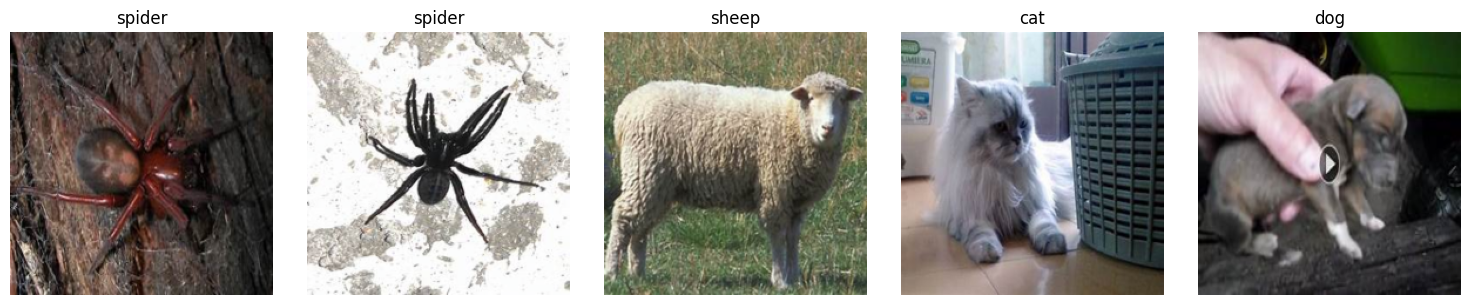

In [4]:
# Visualize some sample images
def show_images(dataloader, num_images=5):
 
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    
    images, labels = next(iter(dataloader))
    
    for i in range(num_images):
        # Convert tensor to numpy and transpose to correct dimensions
        img = images[i].numpy().transpose((1, 2, 0))
        
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        axes[i].imshow(img)
        axes[i].set_title(f"{classes[labels[i]]}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

show_images(train_loader)


In [5]:
# Training the Image Classification Model
# Note: Training can take a long time, so we'll load a pre-trained model for demo purposes

# Ready model is available here:
# https://drive.google.com/drive/folders/1BvGcyRhDOA4UyFLfqQhu5pA0vKHq8CAU?usp=sharing
# If you want to train the model, uncomment and run the following code

# from src.image_classifier.train_model import train_model
# model_save_dir = './models'
# os.makedirs(model_save_dir, exist_ok=True)

# best_acc = train_model(
#     train_loader=train_loader,
#     val_loader=val_loader,
#     classes=classes,
#     num_epochs=5,  # Reduced for demo purposes
#     save_dir=model_save_dir,
#     model_name='animal_classifier'
# )

# print(f"Training completed with best accuracy: {best_acc:.2f}%")

In [6]:
def evaluate_with_inference(test_loader, num_samples=10):
  
    import os
    import torch
    from PIL import Image
    import numpy as np
    from tqdm import tqdm
    import matplotlib.pyplot as plt
    from src.image_classifier.inference import inference
    
    # Create temp directory for saving images
    temp_dir = "temp_test_images"
    os.makedirs(temp_dir, exist_ok=True)
    
    correct = 0
    total = 0
    results = []
    
    try:
        # Process samples from test loader
        with tqdm(total=min(num_samples, len(test_loader.dataset))) as pbar:
            for batch_idx, (images, targets) in enumerate(test_loader):
                for i, (image, target) in enumerate(zip(images, targets)):
                    # Convert tensor to PIL Image
                    img = image.numpy().transpose((1, 2, 0))
                    # Denormalize
                    mean = np.array([0.485, 0.456, 0.406])
                    std = np.array([0.229, 0.224, 0.225])
                    img = std * img + mean
                    img = np.clip(img, 0, 1)
                    img = (img * 255).astype(np.uint8)
                    pil_img = Image.fromarray(img)
                    
                    # Save image temporarily
                    img_path = f"{temp_dir}/temp_img_{batch_idx}_{i}.jpg"
                    pil_img.save(img_path)
                    
                    # Run inference using your existing function
                    result = inference(img_path)
                    
                    # Check if prediction is correct
                    true_class = classes[target.item()]
                    if result['class'] == true_class:
                        correct += 1
                    
                    # Store result
                    results.append({
                        'true_class': true_class,
                        'predicted_class': result['class'],
                        'confidence': result['confidence'],
                        'image_tensor': image,
                        'correct': result['class'] == true_class
                    })
                    
                    total += 1
                    pbar.update(1)
                    
                    # Stop after processing num_samples
                    if total >= num_samples:
                        break
                
                if total >= num_samples:
                    break
        
        # Calculate accuracy
        accuracy = 100 * correct / total
        print(f"Test accuracy: {accuracy:.2f}% ({correct}/{total})")
        
        # Show some examples (correct and incorrect)
        correct_examples = [r for r in results if r['correct']]
        incorrect_examples = [r for r in results if not r['correct']]
        
        # Function to display examples
        def show_examples(examples, title, max_examples=5):
            n = min(len(examples), max_examples)
            if n == 0:
                print(f"No {title} examples to show")
                return
                
            fig, axes = plt.subplots(1, n, figsize=(n*3, 3))
            if n == 1:
                axes = [axes]
                
            for i, example in enumerate(examples[:n]):
                # Convert tensor to image
                img = example['image_tensor'].numpy().transpose((1, 2, 0))
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                img = std * img + mean
                img = np.clip(img, 0, 1)
                
                axes[i].imshow(img)
                axes[i].set_title(f"True: {example['true_class']}\nPred: {example['predicted_class']}\nConf: {example['confidence']:.1f}%")
                axes[i].axis('off')
                
            plt.tight_layout()
            plt.suptitle(title)
            plt.show()
        
        # Show correct and incorrect examples
        show_examples(correct_examples, "Correct Predictions")
        show_examples(incorrect_examples, "Incorrect Predictions")
        
        return {
            'accuracy': accuracy,
            'correct': correct,
            'total': total,
            'results': results
        }
        
    finally:
        # Clean up temporary directory
        import shutil
        shutil.rmtree(temp_dir)

  0%|          | 0/10 [00:00<?, ?it/s]/Users/valeriia/Documents/Work/AIprojects/internship-winstars-ai/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/valeriia/Documents/Work/AIprojects/internship-winstars-ai/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loaded model from epoch 10 with validation accuracy: 95.54%


 10%|█         | 1/10 [00:34<05:12, 34.78s/it]

Loaded model from epoch 10 with validation accuracy: 95.54%


 20%|██        | 2/10 [00:39<02:14, 16.87s/it]

Loaded model from epoch 10 with validation accuracy: 95.54%


 30%|███       | 3/10 [00:42<01:13, 10.55s/it]

Loaded model from epoch 10 with validation accuracy: 95.54%


 40%|████      | 4/10 [00:46<00:47,  7.99s/it]

Loaded model from epoch 10 with validation accuracy: 95.54%


 50%|█████     | 5/10 [00:49<00:32,  6.42s/it]

Loaded model from epoch 10 with validation accuracy: 95.54%


 60%|██████    | 6/10 [00:53<00:22,  5.61s/it]

Loaded model from epoch 10 with validation accuracy: 95.54%


 70%|███████   | 7/10 [00:58<00:16,  5.36s/it]

Loaded model from epoch 10 with validation accuracy: 95.54%


 80%|████████  | 8/10 [01:01<00:09,  4.58s/it]

Loaded model from epoch 10 with validation accuracy: 95.54%


 90%|█████████ | 9/10 [01:04<00:04,  4.01s/it]

Loaded model from epoch 10 with validation accuracy: 95.54%


100%|██████████| 10/10 [01:13<00:00,  7.38s/it]


Test accuracy: 100.00% (10/10)


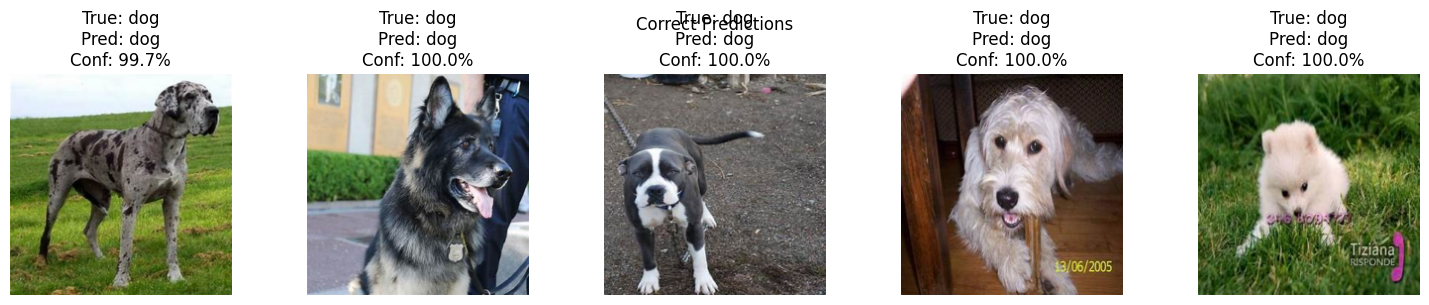

No Incorrect Predictions examples to show


{'accuracy': 100.0,
 'correct': 10,
 'total': 10,
 'results': [{'true_class': 'dog',
   'predicted_class': 'dog',
   'confidence': 99.73205924034119,
   'image_tensor': tensor([[[ 2.2318,  2.2318,  2.2318,  ...,  2.1290,  2.1633,  2.1633],
            [ 2.2147,  2.2147,  2.2147,  ...,  2.0777,  2.1119,  2.1119],
            [ 2.2147,  2.2147,  2.2147,  ...,  2.0605,  2.0948,  2.0948],
            ...,
            [-0.9534, -0.8849, -0.7479,  ..., -1.0048, -0.9877, -0.8849],
            [-0.8678, -1.0219, -1.0048,  ..., -0.9705, -0.9020, -0.8507],
            [-0.7822, -1.0733, -1.1418,  ..., -0.8335, -0.6965, -0.6794]],
   
           [[ 2.3936,  2.3936,  2.3936,  ...,  2.3761,  2.4111,  2.4111],
            [ 2.3936,  2.3936,  2.3936,  ...,  2.3235,  2.3585,  2.3585],
            [ 2.3936,  2.3936,  2.3936,  ...,  2.3060,  2.3410,  2.3410],
            ...,
            [-0.3901, -0.3025, -0.1800,  ..., -0.3375, -0.3025, -0.1800],
            [-0.3025, -0.4251, -0.4251,  ..., -0.2850, 

In [7]:
evaluate_with_inference(test_loader, num_samples=10)

NER Model

NER model

In [8]:
from src.ner.dataset import create_animal_dataset, prepare_dataset
print("\nCreating animal dataset...")
dataset = create_animal_dataset()
print(f"Dataset created with {len(dataset)} examples")


Creating animal dataset...
Dataset created with 140 examples


In [9]:
# Display a few examples
print("\nSample from dataset:")
for i in range(3):
    print(f"Example {i+1}:")
    print(f"  Tokens: {dataset[i]['tokens']}")
    print(f"  Labels: {dataset[i]['labels']}")
        
# Show which tokens are tagged as entities
entities = [token for token, label in zip(dataset[i]['tokens'], dataset[i]['labels']) if label == 1]
print(f"  Entities: {entities}")


Sample from dataset:
Example 1:
  Tokens: ['the', 'dog', 'is', 'here']
  Labels: [0, 1, 0, 0]
Example 2:
  Tokens: ['i', 'see', 'a', 'dog']
  Labels: [0, 0, 0, 1]
Example 3:
  Tokens: ['there', 'is', 'a', 'dog']
  Labels: [0, 0, 0, 1]
  Entities: ['dog']


In [10]:
 # Prepare dataset splits

print("\n2. Preparing dataset splits...")
splits = prepare_dataset(test_size=0.2, val_size=0.2)
print(f"Train set: {len(splits['train'])} examples")
print(f"Validation set: {len(splits['validation'])} examples")
print(f"Test set: {len(splits['test'])} examples")
   
   


2. Preparing dataset splits...
Train set: 89 examples
Validation set: 23 examples
Test set: 28 examples


In [ ]:
from src.ner.train_model import train_ner
print("\nTraining NER model...")
output_dir = "models/ner_checkpoints"
final_model_path = "models/animal_ner_model"
    
epochs = 1  # Set to higher value for better results
    
# Train the model
train_ner(
    output_dir=output_dir,
    final_model_path=final_model_path,
    epochs=epochs,
    batch_size=8,
    disable_wandb=True
)
    
print(f"\nModel training completed and saved to {final_model_path}")
    


Training NER model...


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/89 [00:00<?, ? examples/s]

Map:   0%|          | 0/23 [00:00<?, ? examples/s]

Map:   0%|          | 0/28 [00:00<?, ? examples/s]

/Users/valeriia/Documents/Work/AIprojects/internship-winstars-ai/.venv/lib/python3.12/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/Users/valeriia/Documents/Work/AIprojects/internship-winstars-ai/Task2_NER+_image_classification/src/ner/train_model.py:56: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,No log,0.102145



Model training completed and saved to models/animal_ner_model


In [12]:
from src.ner.inference import run_inference
print("\nTesting inference with trained model...")
    
test_sentences = [
    "I see a dog",
    "The elephant and cat are playing together",
    "Look at the beautiful horse and chicken"
]
    

    
for sentence in test_sentences:
    print(f"\nInput: \"{sentence}\"")
        
    # Test all output formats
    entities_list = run_inference(sentence, final_model_path, output_format="list")
    entities_json = run_inference(sentence, final_model_path, output_format="json")
    entities_verbose = run_inference(sentence, final_model_path, output_format="verbose")
        
    print(f"Detected entities (list): {entities_list}")
    print(f"Detected entities (verbose): {entities_verbose['unique_entities']}")
    print(f"Entity count: {entities_verbose['entity_count']}")
    


Testing inference with trained model...

Input: "I see a dog"
Detected entities (list): ['dog']
Detected entities (verbose): ['dog']
Entity count: 1

Input: "The elephant and cat are playing together"
Detected entities (list): ['elephant', 'cat']
Detected entities (verbose): ['elephant', 'cat']
Entity count: 2

Input: "Look at the beautiful horse and chicken"
Detected entities (list): ['horse', 'chicken']
Detected entities (verbose): ['horse', 'chicken']
Entity count: 2


In [13]:
from src.image_classifier.inference import inference
result = inference("data/elephant.jpeg", classes=['dog', 'horse', 'elephant', 'butterfly', 'chicken', 'cat', 'cow', 'sheep', 'squirrel', 'spider'])
result

/Users/valeriia/Documents/Work/AIprojects/internship-winstars-ai/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/valeriia/Documents/Work/AIprojects/internship-winstars-ai/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loaded model from epoch 10 with validation accuracy: 95.54%


{'class': 'elephant',
 'confidence': 99.99642372131348,
 'class_index': 2,
 'top3': [{'class': 'elephant', 'confidence': 99.99642372131348},
  {'class': 'sheep', 'confidence': 0.003054823901038617},
  {'class': 'horse', 'confidence': 0.0003251835323681007}]}

Testing the whole pipeline

In [14]:
from src.pipeline import AnimalDetectionPipeline

pipeline = AnimalDetectionPipeline()
result = pipeline.process("I see 100 elephants", "data/elephant.jpeg")
    

print(f"Final result: {'Match' if result else 'No match'}")

Using image model: models/animal_classifier.pth
Using NER model: models/animal_ner_model
Using device: cpu
Using animal classes: ['dog', 'horse', 'elephant', 'butterfly', 'chicken', 'cat', 'cow', 'sheep', 'squirrel', 'spider']
No animal was mentioned in the text.
Final result: No match


In [15]:
result = pipeline.process("There are a dog and an elephant", "data/elephant.jpeg")
    

print(f"Final result: {'Match' if result else 'No match'}")

Loaded model from epoch 10 with validation accuracy: 95.54%
Text mentions animals: ['elephant', 'dog']
Image predicted as: elephant (Confidence: 100.00%)
Match found! Text mentions 'elephant' and image contains 'elephant'
Final result: Match


In [16]:
result = pipeline.process("Dog and cat", "data/elephant.jpeg")
    

print(f"Final result: {'Match' if result else 'No match'}")

Loaded model from epoch 10 with validation accuracy: 95.54%
Text mentions animals: ['cat', 'dog']
Image predicted as: elephant (Confidence: 100.00%)
Final result: No match


In [17]:
result = pipeline.process("I've seen an elephant", "data/chicken.jpeg")
    

print(f"Final result: {'Match' if result else 'No match'}")

Loaded model from epoch 10 with validation accuracy: 95.54%
Text mentions animals: ['elephant']
Image predicted as: chicken (Confidence: 100.00%)
Final result: No match
